In [1]:
#Get Player IDs (BALLDONTLIE.io)

import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

base_url = "https://www.balldontlie.io/api/v1/players"

player_names = ["Zach LaVine", "DeMar DeRozan", "Nikola Vucevic"]

player_ids = {}
for name in player_names:
    response = requests.get(base_url, params={'search': name})
    if response.status_code == 200:
        data = response.json()
        if data['data']:
            player = data['data'][0]
            player_ids[name] = player['id']
    else:
        print(f"Failed to retrieve data for {name}. Status code: {response.status_code}")

print(player_ids)

{'Zach LaVine': 268, 'DeMar DeRozan': 125, 'Nikola Vucevic': 460}


In [2]:
#Get Player Info

detailed_data = {}
for name, id in player_ids.items():
    player_url = f"{base_url}/{id}"
    response = requests.get(player_url)
    if response.status_code == 200:
        data = response.json()
        detailed_data[name] = data
    else:
        print(f"Failed to retrieve detailed data for {name}. Status code: {response.status_code}")
import pprint

df = pd.DataFrame.from_dict(detailed_data, orient='index')

df['team_abbreviation'] = df['team'].apply(lambda x: x['abbreviation'])
df['team_city'] = df['team'].apply(lambda x: x['city'])

df = df.drop(columns='team')
df

,id,first_name,height_feet,height_inches,last_name,position,weight_pounds,team_abbreviation,team_city
Zach LaVine,268,Zach,6,5,LaVine,G,200,CHI,Chicago
DeMar DeRozan,125,DeMar,6,7,DeRozan,G,220,CHI,Chicago
Nikola Vucevic,460,Nikola,7,0,Vucevic,C,260,CHI,Chicago


In [3]:
#Get Player Ages and Years Played

player_birthdates = {
    "Zach LaVine": "1995-03-10",
    "DeMar DeRozan": "1989-08-07",
    "Nikola Vucevic": "1990-10-24"
}

player_start_years = {
    "Zach LaVine": 2014,
    "DeMar DeRozan": 2009,
    "Nikola Vucevic": 2011
}

In [4]:
#Add to DataFrame

from datetime import datetime

df['birthdate'] = df.index.map(player_birthdates)
df['birthdate'] = pd.to_datetime(df['birthdate'])
df['age'] = (datetime.now() - df['birthdate']).astype('<m8[Y]').astype(int)

current_year = datetime.now().year
df['start_year'] = df.index.map(player_start_years)
df['years_played'] = current_year - df['start_year']

df['height'] = df['height_feet'].astype(str) + "' " + df['height_inches'].astype(str) + '"'
df = df.drop(columns=['height_feet', 'height_inches', 'team_abbreviation', 'weight_pounds', 'birthdate'])

#Rename team_city
df = df.rename(columns={'team_city': 'team'})

df

,id,first_name,last_name,position,team,age,start_year,years_played,height
Zach LaVine,268,Zach,LaVine,G,Chicago,28,2014,9,"6' 5"""
DeMar DeRozan,125,DeMar,DeRozan,G,Chicago,34,2009,14,"6' 7"""
Nikola Vucevic,460,Nikola,Vucevic,C,Chicago,32,2011,12,"7' 0"""


In [5]:
#Get Player Stats for 2022-23 Season (BALLDONTLIE.io)

base_stats_url = "https://www.balldontlie.io/api/v1/stats"
stats_data = {}
for name, id in player_ids.items():
    player_stats = []
    page = 1
    while True:
        params = {
            'seasons[]': 2022,
            'player_ids[]': id,
            'page': page,
            'per_page': 100  # Request 100 results per page, or whatever the API maximum is
        }
        response = requests.get(base_stats_url, params=params)
        if response.status_code == 200:
            data = response.json()
            if not data['data']:
                break  # exit the loop if no more data
            player_stats.extend(data['data'])
            page += 1  # go to the next page
        else:
            print(f"Failed to retrieve stats for {name}. Status code: {response.status_code}")
            break
    stats_data[name] = player_stats

#Clean up data

df_list = []
for player, stats in stats_data.items():
    df = pd.DataFrame(stats)
    df['player_name'] = player
    df_list.append(df)

final_df = pd.DataFrame([item for sublist in stats_data.values() for item in sublist])

final_df['player_name'] = final_df['player'].apply(lambda x: x['first_name'] + ' ' + x['last_name'])

final_df['team'] = final_df['team'].apply(lambda x: x['abbreviation'] if isinstance(x, dict) and 'abbreviation' in x else np.nan)

columns_to_drop = [col for col in final_df.columns if isinstance(col, float) or col == 'player']
final_df = final_df.drop(columns=columns_to_drop)
final_df['game_date'] = final_df['game'].apply(lambda x: x['date'] if isinstance(x, dict) and 'date' in x else np.nan)
final_df['game_date'] = pd.to_datetime(final_df['game_date']).dt.date

cols = ['player_name', 'team', 'game_date'] + [col for col in final_df if col not in ['player_name', 'team', 'game_date']]
final_df['game_date'] = pd.to_datetime(final_df['game_date']).dt.strftime('%d-%m-%Y')

final_df = final_df[cols]

final_df = final_df.drop(columns=['game'])
final_df = final_df.drop(columns=['id'])

final_df

,player_name,team,game_date,ast,blk,dreb,fg3_pct,fg3a,fg3m,fg_pct,...,ft_pct,fta,ftm,min,oreb,pf,pts,reb,stl,turnover
0,Zach LaVine,CHI,21-10-2022,0,0,0,0.000000,0,0,0.000000,...,0.000,0,0,00,0,0,0,0,0,0
1,Zach LaVine,CHI,24-10-2022,2,1,2,0.600000,5,3,0.333000,...,0.857,7,6,32,0,0,19,2,1,3
2,Zach LaVine,CHI,19-10-2022,0,0,0,0.000000,0,0,0.000000,...,0.000,0,0,00,0,0,0,0,0,0
3,Zach LaVine,CHI,26-10-2022,5,0,6,0.750000,8,6,0.462000,...,0.833,12,10,35,0,1,28,6,1,5
4,Zach LaVine,CHI,28-10-2022,0,0,0,0.000000,0,0,0.000000,...,0.000,0,0,00,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,Nikola Vucevic,CHI,05-04-2023,4,0,9,0.166667,6,1,0.428571,...,1.000,2,2,34,2,2,21,11,0,3
248,Nikola Vucevic,CHI,07-04-2023,4,0,9,0.333333,3,1,0.636364,...,1.000,5,5,28,1,1,20,10,0,1
249,Nikola Vucevic,CHI,09-04-2023,0,0,7,0.000000,0,0,0.444444,...,0.000,0,0,17,0,1,8,7,3,0
250,Nikola Vucevic,CHI,12-04-2023,4,1,12,0.000000,4,0,0.428571,...,1.000,2,2,39,1,3,14,13,1,1


In [6]:
#Get Player Averages for 2022-23 Season (BALLDONTLIE.io)

base_averages_url = "https://www.balldontlie.io/api/v1/season_averages"

player_ids = {
    "Zach LaVine": 268,
    "DeMar DeRozan": 125,
    "Nikola Vucevic": 460
}

averages_data = []

for name, id in player_ids.items():
    params = {
        'season': 2022, 
        'player_ids[]': id
    }
    response = requests.get(base_averages_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        player_averages = data['data'][0] 
        player_averages['player_name'] = name
        averages_data.append(player_averages)
    else:
        print(f"Failed to retrieve stats for {name}. Status code: {response.status_code}")

averages_df = pd.DataFrame(averages_data)

cols = ['player_name', 'player_id'] + [col for col in averages_df.columns if col not in ['player_name', 'player_id']]

averages_df = averages_df[cols]

(averages_df)

,player_name,player_id,games_played,season,min,fgm,fga,fg3m,fg3a,ftm,...,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct
0,Zach LaVine,268,79,2022,36:02,8.75,18.11,2.61,7.05,4.80,...,4.49,4.20,0.90,0.23,2.57,2.06,24.90,0.483,0.370,0.846
1,DeMar DeRozan,125,76,2022,36:24,8.89,17.64,0.61,1.91,6.14,...,4.66,5.12,1.11,0.50,2.05,2.53,24.54,0.504,0.317,0.870
2,Nikola Vucevic,460,84,2022,33:32,7.25,13.94,1.44,4.19,1.60,...,11.01,3.21,0.73,0.69,1.68,2.20,17.54,0.520,0.344,0.837


In [7]:
#Get Player Salaries (Sportrac)

url = "https://www.spotrac.com/nba/rankings/2022-23/base/chicago-bulls/"

tables = pd.read_html(url)

df = tables[0]

df = df.dropna(axis=1, how="all")
df.columns = ["Unnamed: 0", "Player", "Position", "Age", "Base"]
df = df.drop('Unnamed: 0', axis=1)
df['Player'] = df['Player'].str.replace('  CHI', '')

players_of_interest = ['Zach LaVine', 'DeMar DeRozan', 'Nikola Vucevic']
filtered_df = df[df['Player'].isin(players_of_interest)]

filtered_df

,Player,Position,Age,Base
0,Zach LaVine,SG,27,"$37,096,500"
1,DeMar DeRozan,SF,33,"$27,300,000"
2,Nikola Vucevic,C,32,"$22,000,000"


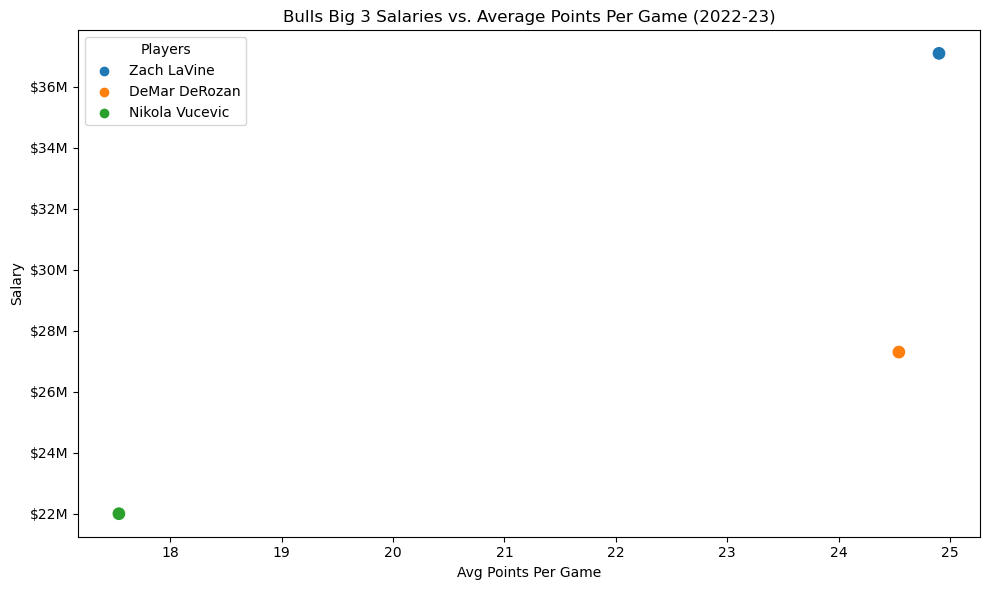

In [15]:
#Compare Big 3 Salaries vs Avg PPG using Scatter Plot

merged_df = pd.merge(averages_df, filtered_df, left_on='player_name', right_on='Player', how='inner')

merged_df['Base'] = merged_df['Base'].str.replace(',', '', regex=True).str.replace('\$', '', regex=True).astype(float)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='pts', y='Base', hue='player_name', s=100, palette='tab10')

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '${:.0f}M'.format(x*1e-6)))

plt.xlabel('Avg Points Per Game')
plt.ylabel('Salary')
plt.title('Bulls Big 3 Salaries vs. Average Points Per Game (2022-23)')
plt.legend(title='Players')

plt.tight_layout()
plt.show()

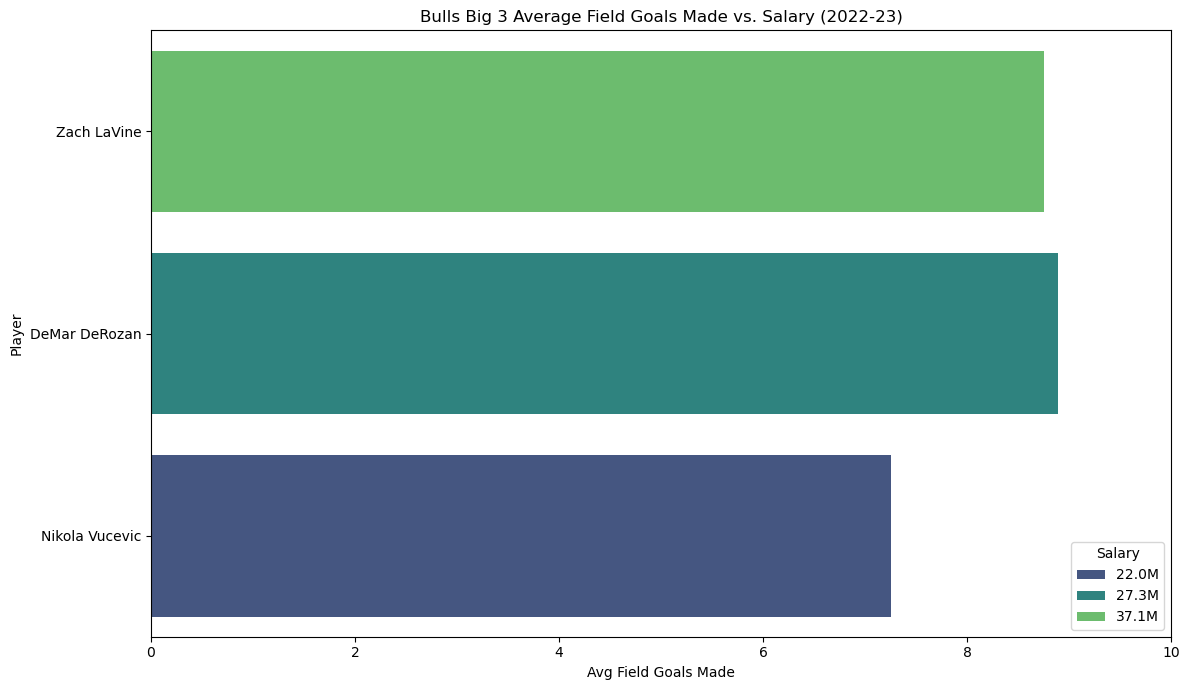

In [14]:
#Compare Big 3 Salaries vs Avg FGM using Bar Graph

merged_df = pd.merge(averages_df, filtered_df, left_on='player_name', right_on='Player', how='inner')
merged_df['Base'] = merged_df['Base'].str.replace(',', '', regex=True).str.replace('\$', '', regex=True).astype(float)

plt.figure(figsize=(12, 7))

sns.barplot(data=merged_df, x='fgm', y='player_name', hue='Base', dodge=False, palette='viridis')

plt.xlabel('Avg Field Goals Made')
plt.ylabel('Player')
plt.title('Bulls Big 3 Average Field Goals Made vs. Salary (2022-23)')
plt.legend(title='Salary', loc='lower right')

legend_labels, _= plt.gca().get_legend_handles_labels()
plt.legend(legend_labels, [f"{float(label)/10**6:.1f}M" for label in _], title='Salary', loc='lower right')

plt.xlim(0, 10)
plt.tight_layout()
plt.show()

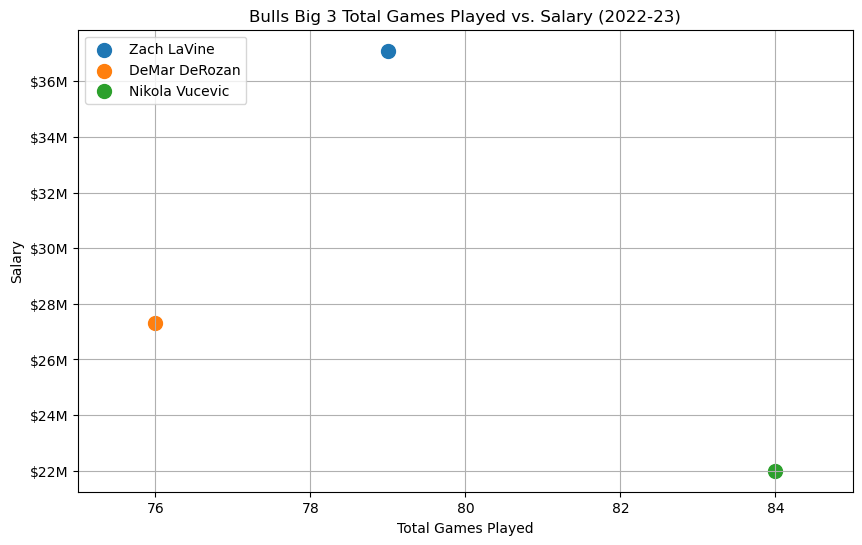

In [10]:
#Compare Big 3 Salaries vs Total Games Played Using Scatter Plot

if merged_df['Base'].dtype == 'O':
   merged_df['Base'] = merged_df['Base'].str.replace(',', '').str.replace('$', '').astype(float)

plt.figure(figsize=(10,6))
for i, player in enumerate(merged_df['player_name']):
    plt.scatter(merged_df.loc[i, 'games_played'], merged_df.loc[i, 'Base'], label=player, s=100)

plt.title("Bulls Big 3 Total Games Played vs. Salary (2022-23)")
plt.xlabel("Total Games Played")
plt.ylabel("Salary")
plt.legend(loc='upper left')
plt.grid(True)
plt.xlim(75, 85)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '${:.0f}M'.format(x*1e-6)))

plt.show()

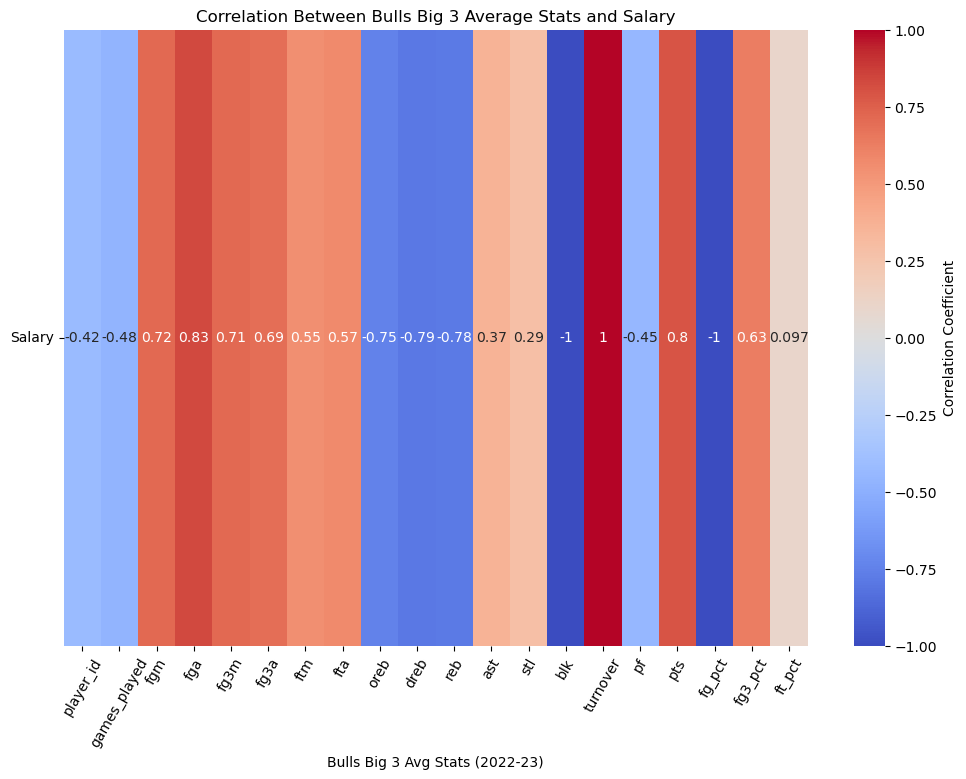

In [16]:
# Compare Correlation Between Bulls Big 3 Stats vs Salary Using Heatmap

player_salaries = dict(zip(filtered_df['Player'], filtered_df['Base']))

player_salaries = {player: float(salary.replace('$', '').replace(',', '')) for player, salary in player_salaries.items()}

if 'player_name' not in averages_df.columns:
    averages_df = averages_df.reset_index()

if 'season' in averages_df.columns:
    averages_df = averages_df.drop('season', axis=1)

averages_df['Salary'] = averages_df['player_name'].map(player_salaries)

correlations = averages_df.corr(numeric_only=True).loc['Salary'].drop('Salary')

plt.figure(figsize=(12, 8))
sns.heatmap(correlations.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Between Bulls Big 3 Average Stats and Salary')
ax = plt.gca()
ax.set_xlabel('Bulls Big 3 Avg Stats (2022-23)')
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.show()

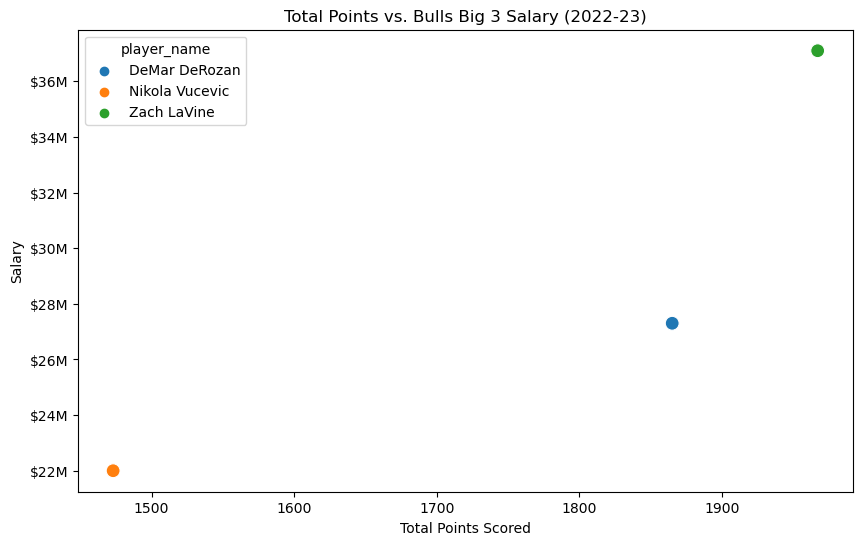

In [12]:
#Compare Bulls Big 3 Salary vs Total Points Scored (2022-23) Using Scatter Plot

total_points = final_df.groupby('player_name')['pts'].sum().reset_index()

total_points['Salary'] = total_points['player_name'].map(player_salaries)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pts', y='Salary', data=total_points, hue='player_name', s=100, palette="tab10")

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '${:.0f}M'.format(x*1e-6)))

plt.title('Total Points vs. Bulls Big 3 Salary (2022-23)')
plt.xlabel('Total Points Scored')
plt.ylabel('Salary')
plt.show()